<a href="https://colab.research.google.com/github/febriantimayori/PCVK_Ganjil_2024/blob/main/Week11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MODUL 11 – Metode Deteksi Objek: Template Matching, Edge Detection, Corner Detection, Grid Detection, Contour Detection**

---


> Nama: Febrianti Mayori

> NIM: 2241720248

> Kelas: TI-3D

## **TUGAS PRAKTIKUM**

---


**1. Buka Google Colab, kemudian import beberapa library dan akses folder yang ada di Drive Anda dengan cara sebagai berikut.**

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


**2. Implementasikan 6 metode template matching pada OpenCV dengan menggunakan gambar cats_and_bunnies.jpg dan cat2_templatejpg.jpg sebagai templatenya.**
> Menggunakan library openCV: `cv.matchTemplate()`, dengan parameter:
> * **image**: citra input
> * **templ**: template yang dicari, ukurannya tidak boleh lebih besar dari citra input
> * **method**: metode dari template matching


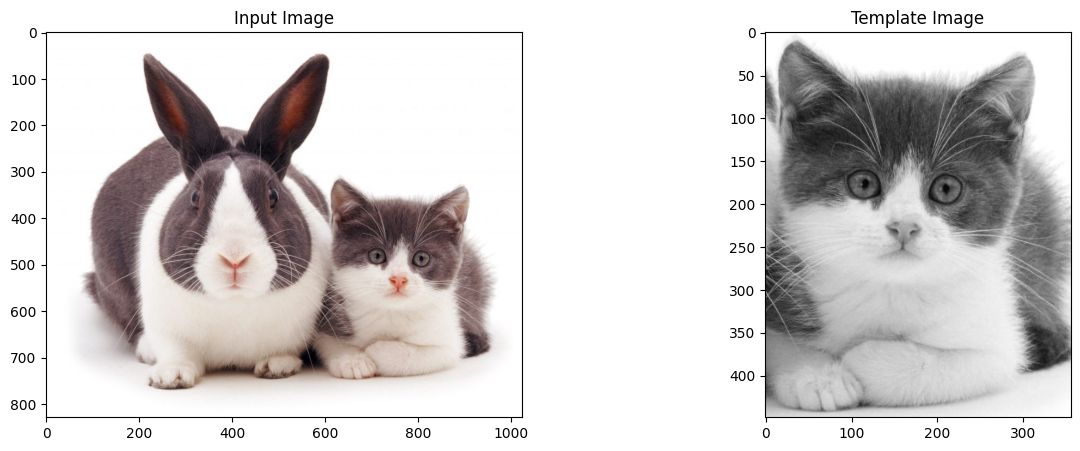

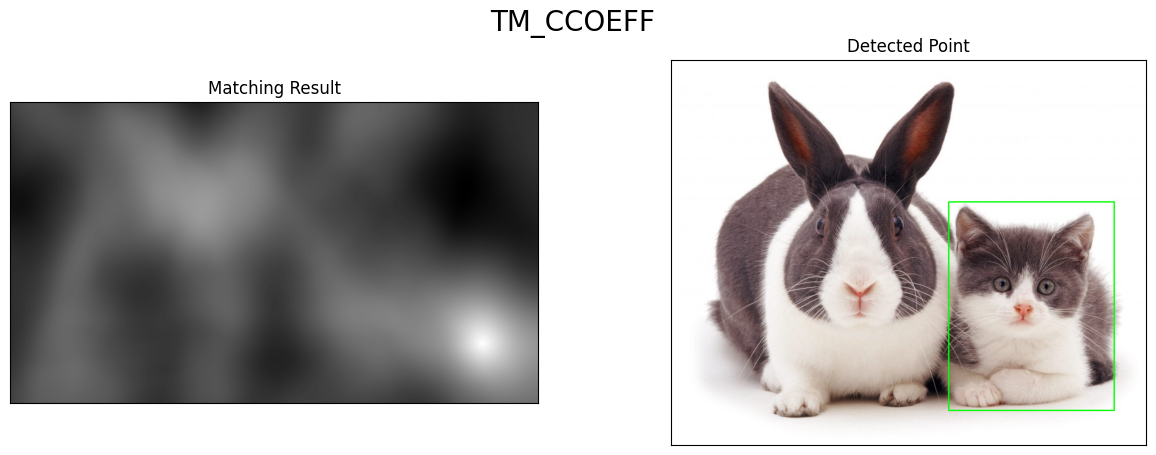

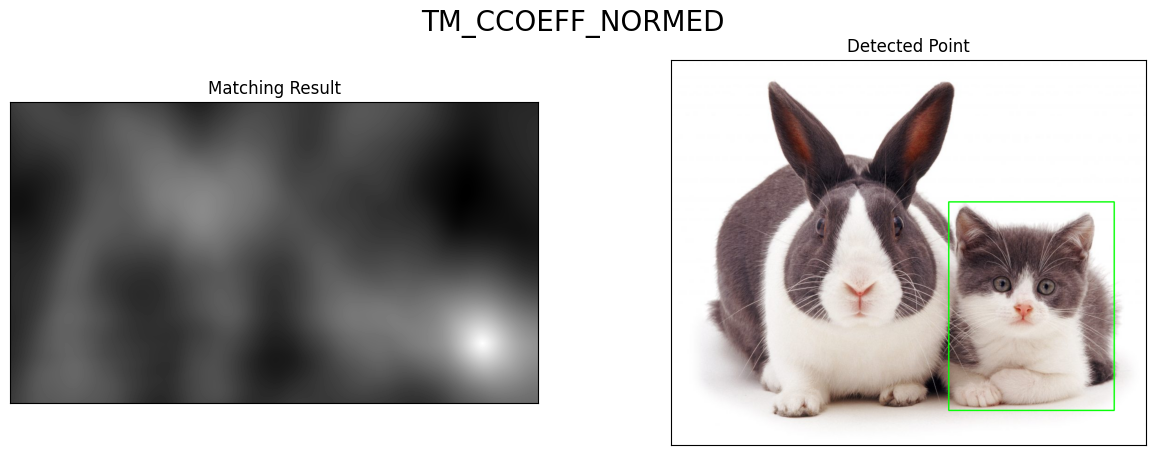

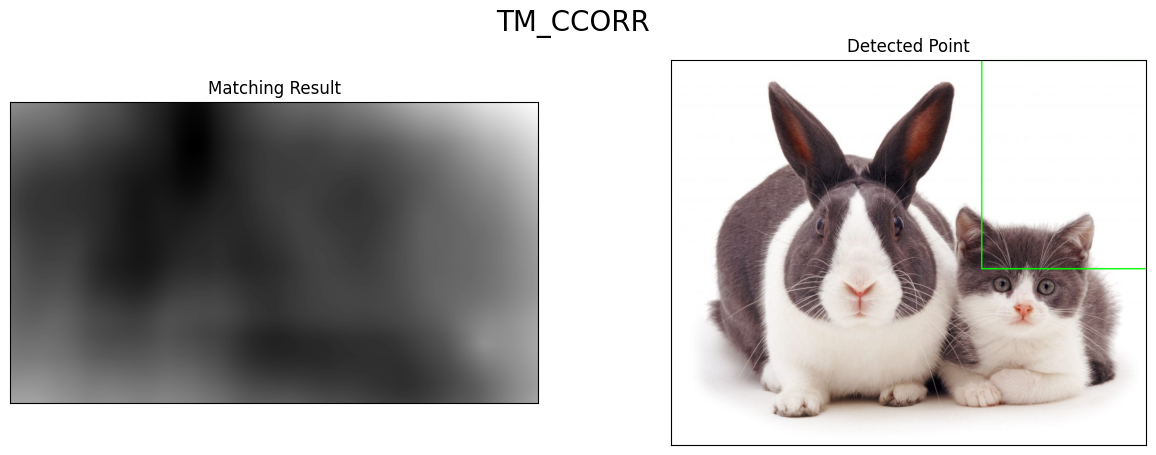

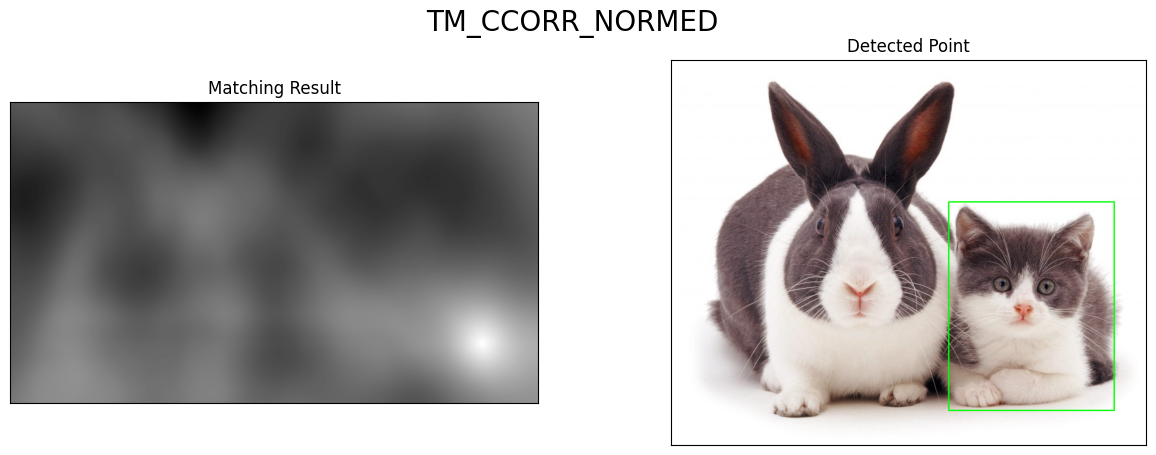

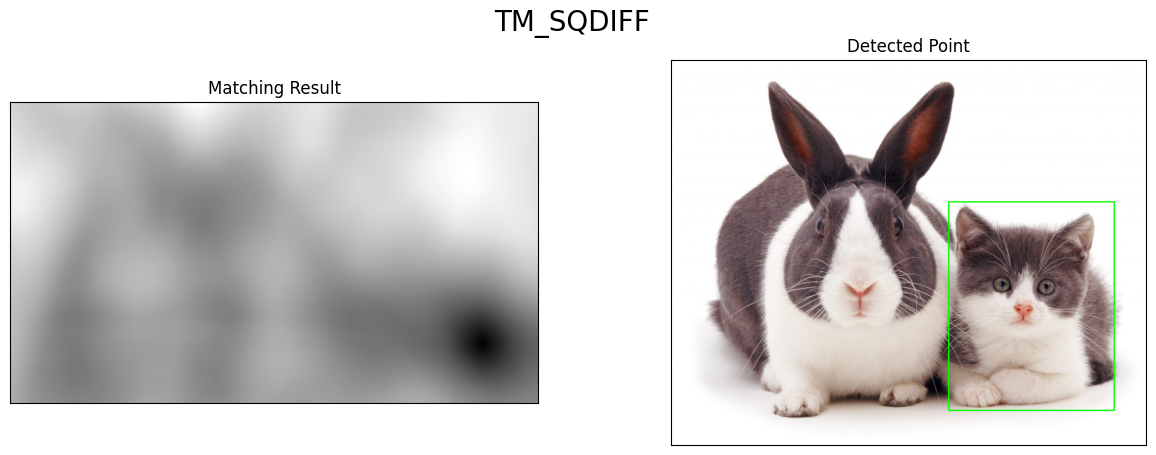

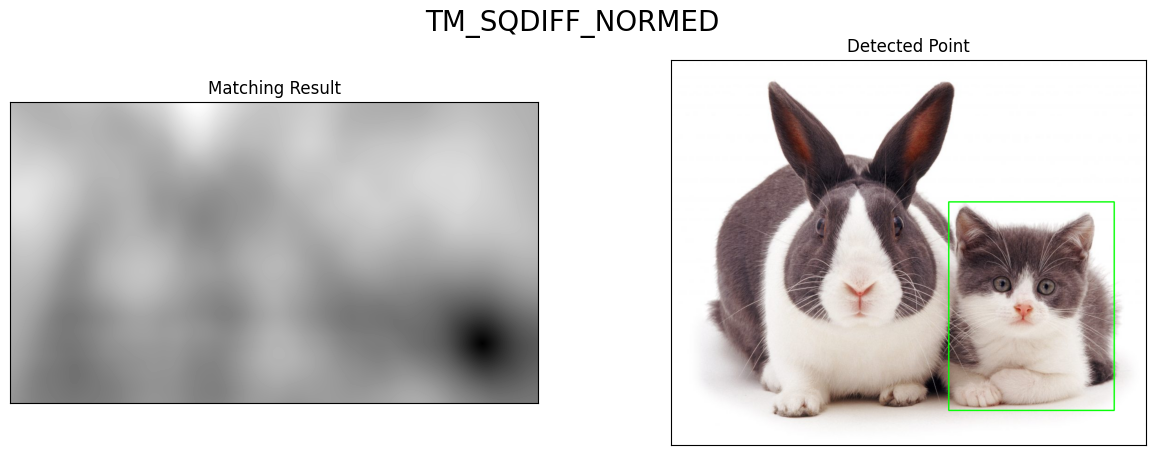

In [3]:
# Memuat citra utama dan template dalam grayscale
image_main = cv.imread('/content/drive/MyDrive/PCVK/Images/Object Detection/cats_and_bunnies.jpg')
image_main_gray = cv.cvtColor(image_main, cv.COLOR_BGR2GRAY)
image_copy = image_main.copy()

template = cv.imread('/content/drive/MyDrive/PCVK/Images/Object Detection/cat2_templatejpg.jpg', 0)
template_width, template_height = template.shape[::-1]

# Menampilkan citra input dan template
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(cv.cvtColor(image_main, cv.COLOR_BGR2RGB))
axes[0].set_title("Input Image")
axes[1].imshow(template, cmap='gray')
axes[1].set_title("Template Image")

# Daftar metode template matching
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
           'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']

# Menerapkan setiap metode dan menampilkan hasilnya
for method_name in methods:
    # Membuat salinan citra untuk menampilkan hasil
    image_result = image_copy.copy()
    method = eval(method_name)

    # Menerapkan template matching
    match_result = cv.matchTemplate(image_main_gray, template, method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(match_result)

    # Menentukan titik sudut kiri atas berdasarkan metode
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + template_width, top_left[1] + template_height)

    # Menggambar kotak di sekitar area yang cocok
    cv.rectangle(image_result, top_left, bottom_right, (0, 255, 0), 2)

    # Menampilkan hasil pencocokan dan deteksi
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.imshow(match_result, cmap='gray')
    plt.title('Matching Result')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122)
    plt.imshow(cv.cvtColor(image_result, cv.COLOR_BGR2RGB))
    plt.title('Detected Point')
    plt.xticks([]), plt.yticks([])

    # Menampilkan nama metode yang digunakan sebagai judul
    plt.suptitle(method_name.replace('cv.', ''), fontsize=20)
    plt.show()

**3. Implementasikan konsep template matching tanpa menggunakan library OpenCV untuk multiple object, menggunakan gambar bahrain.jpg untuk citra masukan dan bahrain-template.jpg sebagai citra template, sehingga menghasilkan output sebagai berikut:**

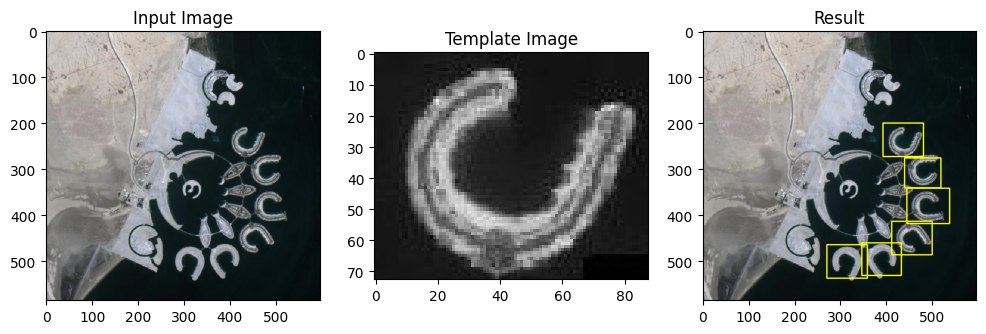

In [4]:
def match_template(image_path, template_path, threshold=0.5):
    # Membaca citra dan template
    image = cv.imread(image_path, cv.IMREAD_COLOR)
    template = cv.imread(template_path, cv.IMREAD_COLOR)

    # Mengubah citra dan template ke grayscale
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    template_gray = cv.cvtColor(template, cv.COLOR_BGR2GRAY)

    # Mendapatkan ukuran template asli
    h, w = template_gray.shape

    # Variabel untuk menyimpan hasil deteksi
    image_plot = image.copy()
    rectangles = []  # Menyimpan semua kotak deteksi

    # Template matching multi-skala dengan skala yang terbatas
    scales = [0.9, 1.0, 1.1]  # Skala template yang lebih mendekati ukuran target
    for scale in scales:
        # Sesuaikan ukuran template
        resized_template = cv.resize(template_gray, (int(w * scale), int(h * scale)))
        h_resized, w_resized = resized_template.shape

        # Lakukan template matching pada skala saat ini
        res = cv.matchTemplate(image_gray, resized_template, cv.TM_CCOEFF_NORMED)

        # Salin hasil matching untuk proses iteratif
        res_copy = res.copy()

        # Cari semua lokasi yang memenuhi threshold secara iteratif
        while True:
            min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res_copy)
            if max_val < threshold:
                break

            # Tambahkan semua kotak deteksi ke daftar
            rectangles.append([max_loc[0], max_loc[1], w_resized, h_resized])

            # Hapus area yang sudah dideteksi dari res_copy
            res_copy[max_loc[1]:max_loc[1] + h_resized, max_loc[0]:max_loc[0] + w_resized] = 0

    # Non-Maximum Suppression untuk mengurangi kotak deteksi ganda
    rectangles, _ = cv.groupRectangles(rectangles, groupThreshold=1, eps=0.3)

    # Gambarkan semua kotak deteksi yang disaring
    for (x, y, w, h) in rectangles:
        cv.rectangle(image_plot, (x, y), (x + w, y + h), (0, 255, 255), 2)

    # Mengonversi citra hasil ke RGB
    image_rgb = cv.cvtColor(image_plot, cv.COLOR_BGR2RGB)

    # Menampilkan gambar input, template, dan hasil
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    # Gambar input image
    ax[0].imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    ax[0].set_title('Input Image')
    ax[0].axis('on')

    # Gambar template
    ax[1].imshow(template_gray, cmap='gray')
    ax[1].set_title('Template Image')
    ax[1].axis('on')

    # Gambar hasil dengan kotak deteksi
    ax[2].imshow(image_rgb)
    ax[2].set_title('Result')
    ax[2].axis('on')

    plt.show()

# Menentukan jalur citra dan template, kemudian memanggil fungsi
image_path = '/content/drive/MyDrive/PCVK/Images/Object Detection/bahrain.jpg'
template_path = '/content/drive/MyDrive/PCVK/Images/Object Detection/bahrain-template.jpg'
match_template(image_path, template_path, threshold=0.45)

**4. Implementasikan metode Sobel Edge Detection, Canny Edge Detection, dan Laplacian Edge Detection pada OpenCV dengan menggunakan gambar car-park.jpg, sehingga menghasilkan luaran sebagai berikut:**

**a. Sobel Edge Detection:**

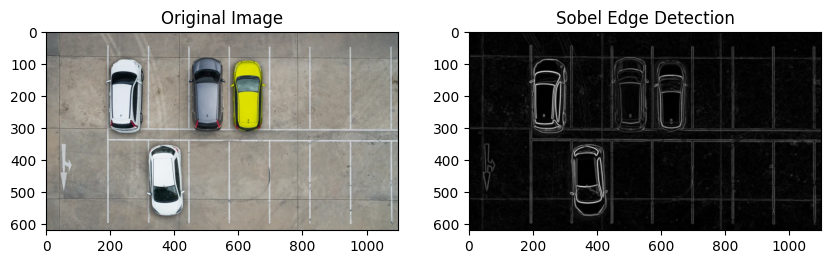

In [5]:
# Membaca gambar
img = cv.imread('/content/drive/MyDrive/PCVK/Images/Object Detection/car-park.jpg')

# Sobel Edge Detection Function
def sobel_edge_detection(image):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    blurred = cv.GaussianBlur(gray, (5, 5), 0)
    grad_x = cv.Sobel(blurred, cv.CV_64F, 1, 0, ksize=5)
    grad_y = cv.Sobel(blurred, cv.CV_64F, 0, 1, ksize=5)
    gradient_magnitude = cv.magnitude(grad_x, grad_y)
    gradient_normalized = cv.normalize(gradient_magnitude, None, 0, 255, cv.NORM_MINMAX, dtype=cv.CV_8U)
    return gradient_normalized

# Apply Sobel Edge Detection
sobel_edges = sobel_edge_detection(img)

# Display Original and Sobel Edge Detection Result Side by Side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
ax[0].set_title('Original Image')
ax[1].imshow(sobel_edges, cmap='gray')
ax[1].set_title('Sobel Edge Detection')
plt.show()

**b. Canny Edge Detection:**

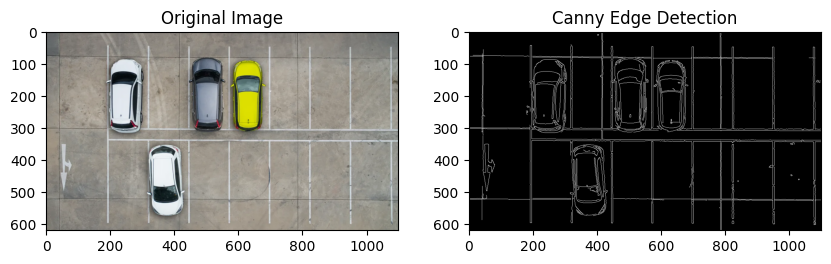

In [6]:
# Canny Edge Detection Function
def canny_edge_detection(image, threshold1=50, threshold2=150):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    blurred = cv.GaussianBlur(gray, (5, 5), 0)
    edges = cv.Canny(blurred, threshold1, threshold2)
    return edges

# Apply Canny Edge Detection
canny_edges = canny_edge_detection(img)

# Display Original and Canny Edge Detection Result Side by Side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
ax[0].set_title('Original Image')
ax[1].imshow(canny_edges, cmap='gray')
ax[1].set_title('Canny Edge Detection')
plt.show()

**c. Laplacian Edge Detection:**

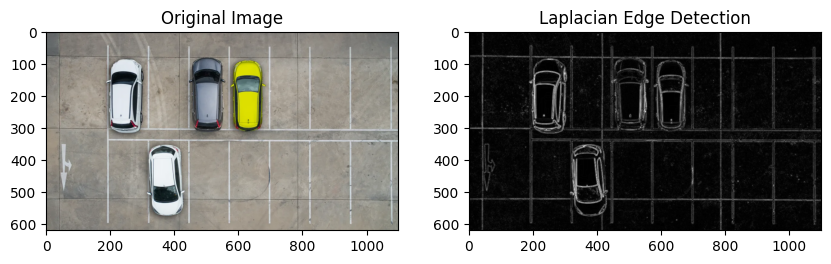

In [7]:
# Laplacian Edge Detection Function
def laplacian_edge_detection(image):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    blurred = cv.GaussianBlur(gray, (3, 3), 0)
    edges = cv.Laplacian(blurred, cv.CV_64F, ksize=3)
    edges_abs = cv.convertScaleAbs(edges)
    return edges_abs

# Apply Laplacian Edge Detection
laplacian_edges = laplacian_edge_detection(img)

# Display Original and Laplacian Edge Detection Result Side by Side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
ax[0].set_title('Original Image')
ax[1].imshow(laplacian_edges, cmap='gray')
ax[1].set_title('Laplacian Edge Detection')
plt.show()

**5. Implementasikan metode Harris Corner Detection dan Shi-Tomasi Detection pada OpenCV dengan menggunakan gambar chess-board.jpg, sehingga menghasilkan luaran sebagai berikut:**

**a. Harris Corner Detection:**

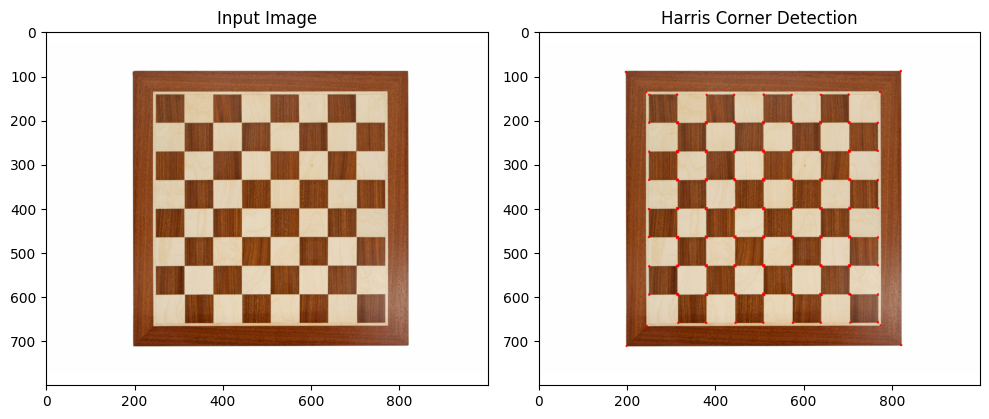

In [8]:
class HarrisCornerDetection:
    def __init__(self, image_path):
        self.image_path = image_path
        self.image_rgb = None
        self.image_gray = None
        self.load_image()

    def load_image(self):
        image = cv.imread(self.image_path)
        self.image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        self.image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    def detect_corners(self):
        harris_corners = cv.cornerHarris(self.image_gray, blockSize=3, ksize=5, k=0.05)
        harris_corners = cv.dilate(harris_corners, None)

        # Menggambar hasil deteksi
        image_harris = self.image_rgb.copy()
        image_harris[harris_corners > 0.02 * harris_corners.max()] = [255, 0, 0]
        return image_harris

    def plot_result(self):
        image_harris = self.detect_corners()

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(self.image_rgb)
        axes[0].set_title('Input Image')
        axes[0].axis('on')

        axes[1].imshow(image_harris)
        axes[1].set_title('Harris Corner Detection')
        axes[1].axis('on')

        plt.tight_layout()
        plt.show()

# Eksekusi deteksi sudut Harris
if __name__ == "__main__":
    image_path = '/content/drive/MyDrive/PCVK/Images/Object Detection/chess-board.jpg'
    harris_detector = HarrisCornerDetection(image_path)
    harris_detector.plot_result()

**b. Shi-Tomasi Detection:**

<ipython-input-9-a28412ff50cb>:21: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


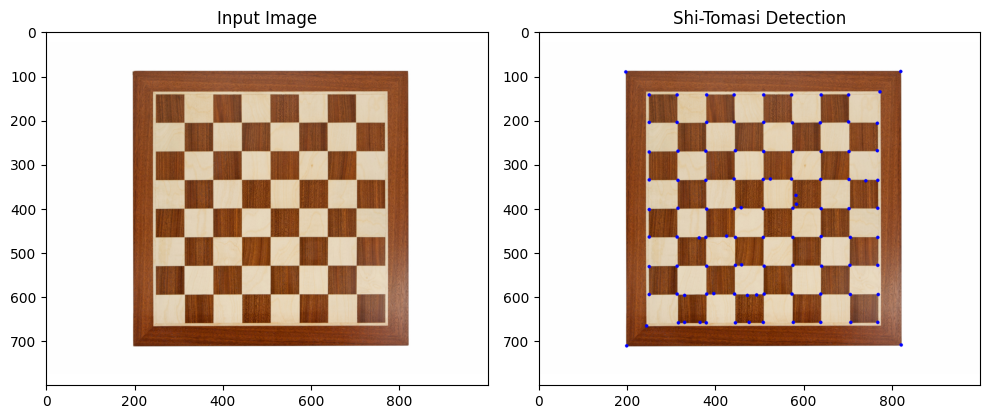

In [9]:
class ShiTomasiDetection:
    def __init__(self, image_path):
        self.image_path = image_path
        self.image_rgb = None
        self.image_gray = None
        self.load_image()

    def load_image(self):
        image = cv.imread(self.image_path)
        self.image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        self.image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    def detect_corners(self):
        # Menggunakan deteksi Shi-Tomasi dengan parameter yang lebih presisi
        corners = cv.goodFeaturesToTrack(
            self.image_gray,
            maxCorners=100,
            qualityLevel=0.01,
            minDistance=10
        )
        corners = np.int0(corners)

        # Menggambar sudut terdeteksi pada salinan gambar asli
        image_shi_tomasi = self.image_rgb.copy()
        for corner in corners:
            x, y = corner.ravel()
            cv.circle(image_shi_tomasi, (x, y), 4, (0, 0, 255), -1)
        return image_shi_tomasi

    def plot_result(self):
        image_shi_tomasi = self.detect_corners()

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(self.image_rgb)
        axes[0].set_title('Input Image')
        axes[0].axis('on')

        axes[1].imshow(image_shi_tomasi)
        axes[1].set_title('Shi-Tomasi Detection')
        axes[1].axis('on')

        plt.tight_layout()
        plt.show()

# Eksekusi deteksi sudut Shi-Tomasi
if __name__ == "__main__":
    image_path = '/content/drive/MyDrive/PCVK/Images/Object Detection/chess-board.jpg'
    shi_tomasi_detector = ShiTomasiDetection(image_path)
    shi_tomasi_detector.plot_result()

**6. Implementasikan metode Hough Transform pada OpenCV dengan menggunakan gambar sudoku.jpg. Tahapan proses grid detection sesuai yang terdapat pada ulasan teori, sehingga menghasilkan luaran sebagai berikut:**

Jumlah garis Hough awal: 33
Jumlah garis setelah disaring: 20


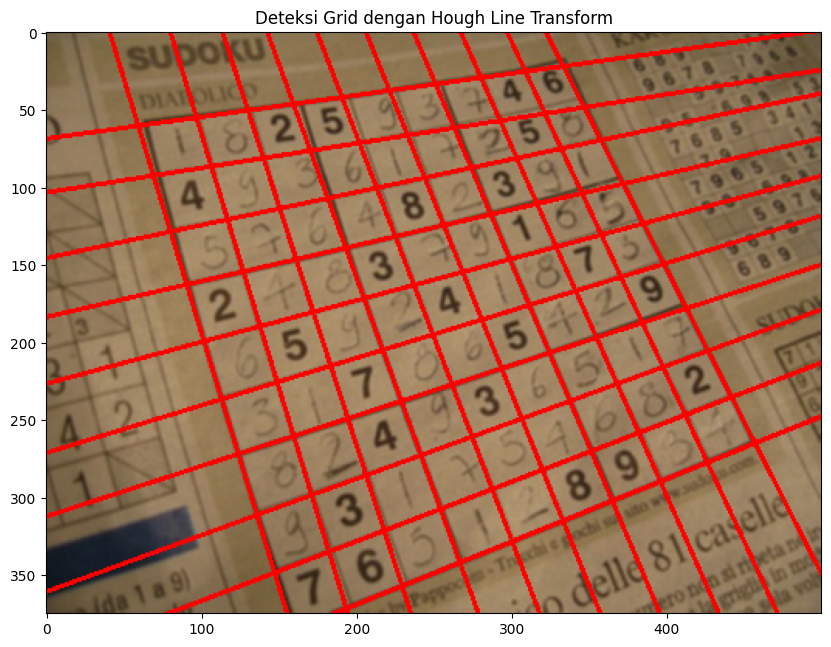

In [10]:
def hough_lines_detection(input_img_path):
    # Membaca dan memproses gambar input
    input_img = cv.imread(input_img_path)
    img_gray = cv.cvtColor(input_img, cv.COLOR_BGR2GRAY)

    # Deteksi tepi menggunakan Canny dengan threshold yang sama seperti kode awal
    edges = cv.Canny(img_gray, 90, 150, apertureSize=3)

    # Melakukan dilasi dengan kernel (3, 3) dan erosi dengan kernel (5, 5)
    edges = cv.dilate(edges, np.ones((3, 3), np.uint8), iterations=1)
    edges = cv.erode(edges, np.ones((5, 5), np.uint8), iterations=1)

    # Menggunakan Transformasi Hough untuk deteksi garis
    lines = cv.HoughLines(edges, 1, np.pi / 180, 150)

    # Jika tidak ada garis yang terdeteksi, berikan pesan
    if lines is None:
        print('Tidak ada garis yang terdeteksi')
        return None

    # Menetapkan threshold untuk menggabungkan garis yang serupa
    rho_threshold = 15  # kembali ke nilai threshold awal
    theta_threshold = 0.1

    # Menyaring garis-garis berdasarkan kemiripan untuk menghindari duplikasi
    unique_lines = []
    for i in range(len(lines)):
        rho_i, theta_i = lines[i][0]
        duplicate = False
        for rho_j, theta_j in unique_lines:
            if abs(rho_i - rho_j) < rho_threshold and abs(theta_i - theta_j) < theta_threshold:
                duplicate = True
                break
        if not duplicate:
            unique_lines.append((rho_i, theta_i))

    # Menampilkan jumlah garis awal dan setelah disaring
    print('Jumlah garis Hough awal:', len(lines))
    print('Jumlah garis setelah disaring:', len(unique_lines))

    # Menggambar garis unik pada gambar asli
    for rho, theta in unique_lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))

        cv.line(input_img, (x1, y1), (x2, y2), (0, 0, 255), 2)

    # Menampilkan hasil akhir
    plt.figure(figsize=(10, 10))
    plt.imshow(cv.cvtColor(input_img, cv.COLOR_BGR2RGB))
    plt.axis('on')
    plt.title('Deteksi Grid dengan Hough Line Transform')
    plt.show()

# Contoh pemanggilan fungsi
input_img_path = '/content/drive/MyDrive/PCVK/Images/Object Detection/sudoku.jpg'
hough_lines_detection(input_img_path)

**7. Implementasikan fungsi findContours() pada OpenCV untuk contour detection dengan menggunakan gambar laptop.jpg, sehingga menghasilkan luaran sebagai berikut:**

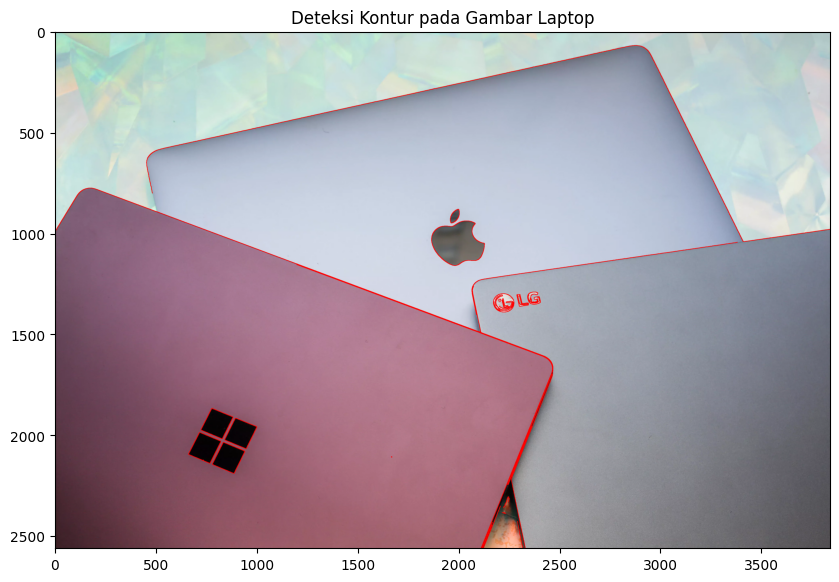

In [11]:
# Fungsi untuk mendeteksi kontur pada gambar
def contour_detection(image_path):
    # Membaca gambar dan mengubahnya menjadi grayscale
    img = cv.imread(image_path)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Menggunakan Gaussian Blur untuk mengurangi noise
    blurred = cv.GaussianBlur(img_gray, (5, 5), 0)

    # Menerapkan deteksi tepi Canny
    edges = cv.Canny(blurred, 50, 150)

    # Menemukan kontur menggunakan findContours
    contours, hierarchy = cv.findContours(edges, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    # Menggambar kontur yang ditemukan pada gambar asli
    img_contours = img.copy()
    cv.drawContours(img_contours, contours, -1, (0, 0, 255), 2)

    # Menampilkan hasil gambar dengan kontur yang ditandai
    plt.figure(figsize=(10, 10))
    plt.imshow(cv.cvtColor(img_contours, cv.COLOR_BGR2RGB))
    plt.axis('on')
    plt.title('Deteksi Kontur pada Gambar Laptop')
    plt.show()

# Memanggil fungsi dengan path gambar
image_path = '/content/drive/MyDrive/PCVK/Images/Object Detection/laptop.jpg'
contour_detection(image_path)

## **Pengayaan Materi KTP**

---

**1. Siapkan file dataset, contoh pada praktik ini menggunakan Maftuchin Tuban.**

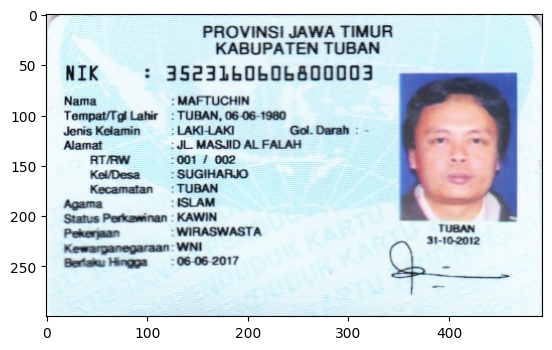

In [81]:
# Tentukan lokasi dataset
ktp_maftuchin = cv2.imread('/content/drive/MyDrive/PCVK/Images/KTP_MORE/ktp3.png')
ktp_maftuchin = cv.cvtColor(ktp_maftuchin, cv.COLOR_BGR2RGB)
plt.imshow(ktp_maftuchin)

**2. Muat 2 library berikut sebagai tahapan persiapan.**

In [82]:
import cv2
import os
import matplotlib.pyplot as plt

**3. Tambahkan kode lokalisasi dataset dan lakukan pembacaan file name di dalam direktori dataset tersebut.**

In [83]:
# Tentukan lokasi direktori dataset
path_plate = '/content/drive/MyDrive/PCVK/Images/KTP_MORE'

# Looping untuk setiap file di dalam direktori
for name_file in sorted(os.listdir(path_plate)):
    # Baca gambar dari file
    src = cv2.imread(os.path.join(path_plate, name_file))
    if src is None:
        continue  # Skip file jika gagal dibaca
    blurred = src.copy()
    gray = blurred.copy()

**4. Masih pada looping file direktori, terapkan Gaussian Blur untuk setiap file supaya noise pickle dapat direduksi.**

In [84]:
# Filtering
for i in range(10):
  blurred = cv2.GaussianBlur(src, (5, 5), 0.5)

**5. Lakukan konversi grayscale untuk setiap hasil citra yang tereduksi noise dan lanjutkan dengan binerisasi citra (thresholding).**

In [85]:
# Ubah ke grayscale
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
ret, bw = cv2.threshold(gray.copy(), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print(ret, bw.shape)

141.0 (488, 800)


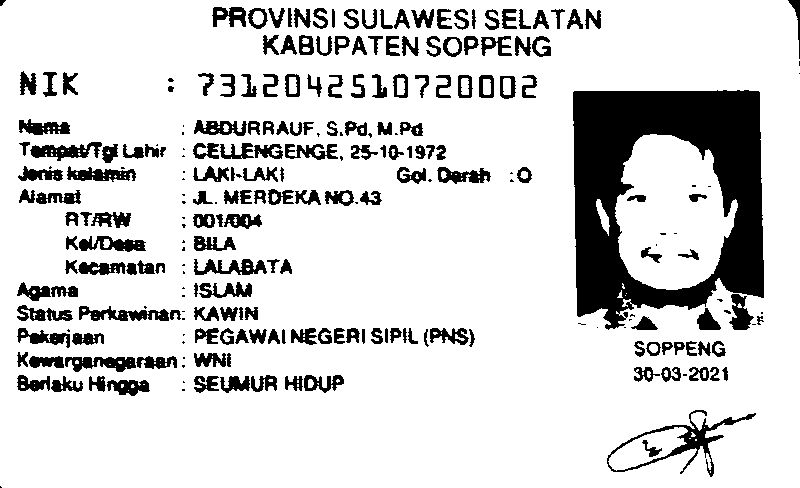

In [86]:
cv2_imshow(bw)

**6. Terapkan morfologi untuk setiap citra yang telah mengalami binerisasi supaya setiap karakter atau obyek tidak berhimpitan.**

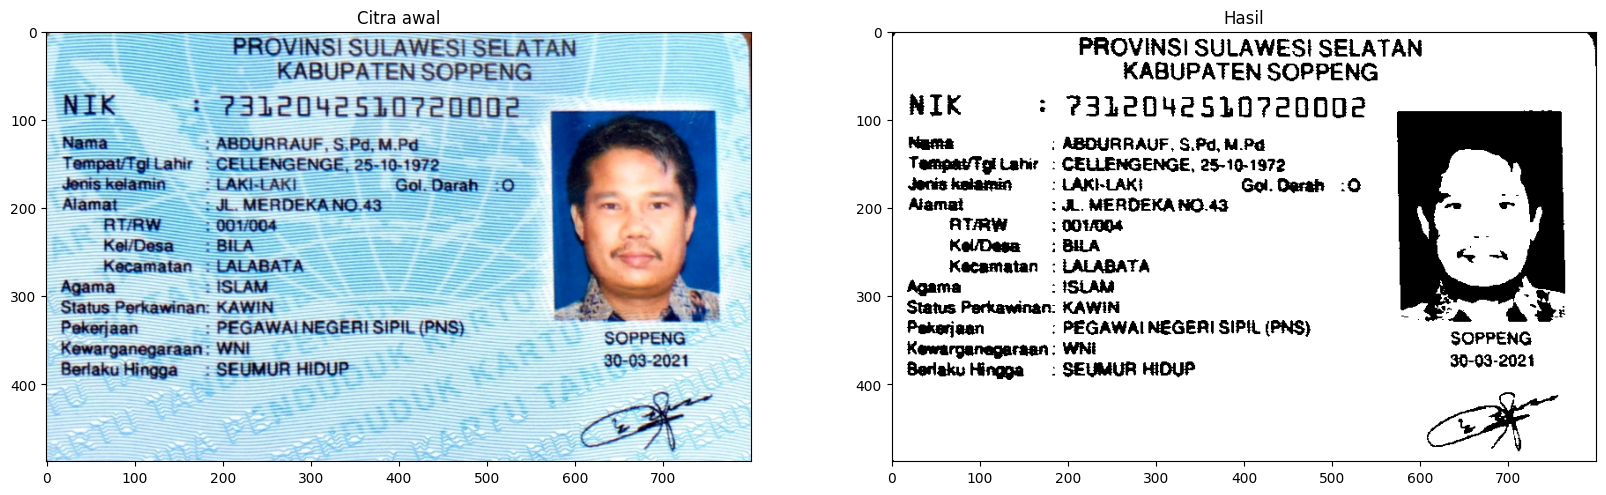

In [87]:
# Tampilkan gambar asli dan hasil deteksi tepi
f, axarr = plt.subplots(1, 2, figsize=(20, 10))
# Menampilkan citra awal (gambar asli)
axarr[0].imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
axarr[0].set_title('Citra awal')

# Menampilkan hasil deteksi tepi (gambar hitam putih)
axarr[1].imshow(bw, cmap='gray')
axarr[1].set_title('Hasil')

plt.show()

**7. Terapkan ekstraksi kontur untuk untuk mendapatkan semua kontur setiap karakter/obyek. Kontur harus diseleksi berdasarkan ukuran dan rasio sebuah karakter. Karakter/obyek di dalam KTP ini bervariasi ukuran dan rasionya, sehingga setiap karakter/obyek perlu penanganan yang berbeda. Contoh pada praktik ini berfokus pada karakter yang seukuran dengan NIK. Jika hasil ekstraksi kontur memperlihatkan hasil lain yaitu karakter lain terdeteksi, hal tersebut wajar karena perlu optimize code dan preprocessing yang lebih baik (karena hasil akuisisi setiap citra dapat berbeda).**

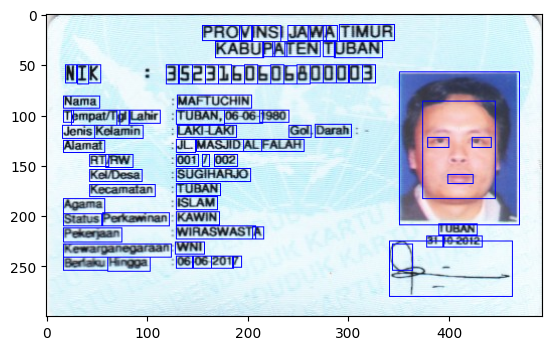

In [97]:
# Membaca gambar
ktp_image = cv.imread('/content/drive/MyDrive/PCVK/Images/KTP_MORE/ktp3.png')

# Melakukan Gaussian Blur untuk mengurangi noise
blurred_image = cv.GaussianBlur(ktp_image, (5, 5), 0.5)

# Konversi gambar menjadi grayscale
gray_image = cv.cvtColor(blurred_image, cv.COLOR_BGR2GRAY)

# Binerisasi menggunakan thresholding Otsu
_, binary_image = cv.threshold(gray_image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

# Operasi morfologi erosi dengan elemen struktur yang sedikit lebih besar
eroded_image = cv.erode(binary_image, cv.getStructuringElement(cv.MORPH_RECT, (2, 2)))

# Ekstraksi kontur dari gambar erosi
contours, _ = cv.findContours(eroded_image, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# Looping untuk menyeleksi kontur berdasarkan ukuran dan rasio
for contour in contours:
    x, y, w, h = cv.boundingRect(contour)
    aspect_ratio = w / h  # Menghitung rasio lebar dan tinggi
    if h >= 40 and w >= 10 and aspect_ratio <= 1:
        cv.rectangle(ktp_image, (x, y), (x + w, y + h), (255, 0, 0), thickness=1)
    elif h >= 8 and w >= 8 and aspect_ratio <= 10:
        cv.rectangle(ktp_image, (x, y), (x + w, y + h), (255, 0, 0), thickness=1)
    elif h >= 10 and w >= 7 and aspect_ratio <= 8:
        cv.rectangle(ktp_image, (x, y), (x + w, y + h), (255, 0, 0), thickness=1)

# Konversi gambar ke RGB untuk ditampilkan dengan plt
ktp_rgb_image = cv.cvtColor(ktp_image, cv.COLOR_BGR2RGB)

# Menampilkan gambar hasil deteksi kontur
plt.imshow(ktp_rgb_image)
plt.show()

## **Tugas Praktikum Materi KTP**

---

**Setiap citra memiliki karakteristik yang berbeda. Terapkan praktik pada materi pengayaan KTP untuk setiap dataset KTP yang tersedia. Perhatikan kondisi awal dataset, terapkan preprocessing yang sesuai jika kualitas visual citra kurang memadai untuk segera diolah. Pengerjaan dilakukan secara berkelompok dengan aturan sebagai berikut:**
1. Kelompok 1 – KTP Riyanto Sleman
2. Kelompok 2 – KTP Galang Raka Bengkulu
3. Kelompok 3 – KTP Arief Wijaya Cimahi
4. Kelompok 4 – KTP Edo Nias
5. Kelompok 5 – KTP Widiarso Bekasi
6. Kelompok 6 – KTP Abdurrauf Soppeng

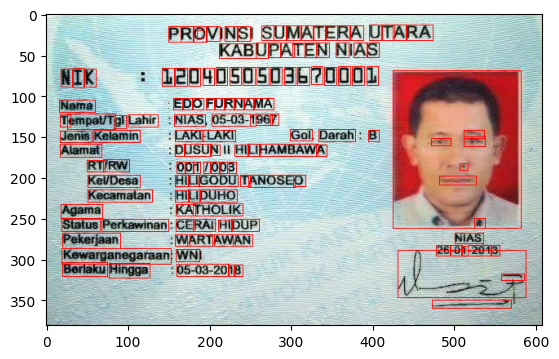

In [109]:
# Membaca gambar
ktp_image = cv.imread('/content/drive/MyDrive/PCVK/Images/KTP_MORE/ktp5.png')

# Melakukan Gaussian Blur untuk mengurangi noise
blurred_image = cv.GaussianBlur(ktp_image, (5, 5), 0.5)

# Konversi gambar menjadi grayscale
gray_image = cv.cvtColor(blurred_image, cv.COLOR_BGR2GRAY)

# Binerisasi menggunakan thresholding Otsu
_, binary_image = cv.threshold(gray_image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

# Operasi morfologi erosi dengan elemen struktur yang sedikit lebih besar
eroded_image = cv.erode(binary_image, cv.getStructuringElement(cv.MORPH_RECT, (2, 2)))

# Ekstraksi kontur dari gambar erosi
contours, _ = cv.findContours(eroded_image, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# Looping untuk menyeleksi kontur berdasarkan ukuran dan rasio
for contour in contours:
    x, y, w, h = cv.boundingRect(contour)
    aspect_ratio = w / h  # Menghitung rasio lebar dan tinggi
    if h >= 40 and w >= 10 and aspect_ratio <= 1:
        cv.rectangle(ktp_image, (x, y), (x + w, y + h), (0, 0, 255), thickness=1)
    elif h >= 8 and w >= 8 and aspect_ratio <= 10:
        cv.rectangle(ktp_image, (x, y), (x + w, y + h), (0, 0, 255), thickness=1)
    elif h >= 10 and w >= 7 and aspect_ratio <= 8:
        cv.rectangle(ktp_image, (x, y), (x + w, y + h), (0, 0, 255), thickness=1)

# Konversi gambar ke RGB untuk ditampilkan dengan plt
ktp_rgb_image = cv.cvtColor(ktp_image, cv.COLOR_BGR2RGB)

# Menampilkan gambar hasil deteksi kontur
plt.imshow(ktp_rgb_image)
plt.show()